Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from pathlib import Path 
import pathlib 
dataset_path = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(dataset_path+'/Train/')
data_dir_test = pathlib.Path(dataset_path+'/Test/')

In [7]:
train_count = len(list(data_dir_train.glob('*/*.jpg')))
print(train_count)
test_count = len(list(data_dir_test.glob('*/*.jpg')))
print(test_count)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
image_height = 180
image_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_data_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path+'/Train/',
    labels="inferred",
    color_mode='rgb',
    shuffle=True, 
    seed=123,
    validation_split=.2,
    image_size=(image_height, image_width),
    subset='training',
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
validation_data_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path+'/Train/',
    labels="inferred",
    color_mode='rgb',
    shuffle=True,
    seed=123,
    validation_split=.2,
    image_size=(image_height, image_width),
    subset='validation',
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_data_set.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

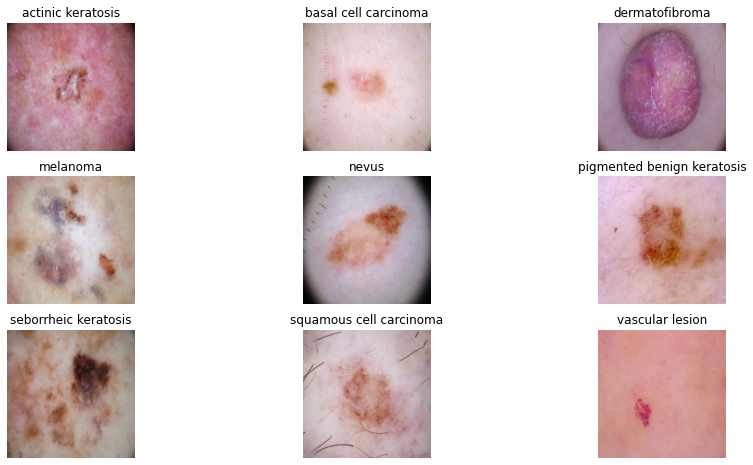

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15, 8))
for i in range(len(class_names)):
    filter_ds = train_data_set.filter(lambda x, l: tf.math.equal(l[0], i))
    for img, label in filter_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img[0].numpy().astype("uint8"))
        plt.title(class_names[label[0]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data_set = train_data_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data_set = validation_data_set.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
nrmlz_layer = tf.keras.layers.Rescaling(1./255)

nrmlz_ds = train_data_set.map(lambda x, y: (nrmlz_layer(x), y))
img_batch, lbl_batch = next(iter(nrmlz_ds))
first_image = img_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.01143757 0.8045749


In [15]:
num_classes = 9

model =  tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs = 20
history = model.fit(
  train_data_set,
  validation_data=validation_data_set,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 68s 1s/step - loss: 1.8606 - accuracy: 0.2868 - val_loss: 1.6822 - val_accuracy: 0.3758
Epoch 2/20
56/56 [==============================] - 6s 114ms/step - loss: 1.5884 - accuracy: 0.4202 - val_loss: 1.5386 - val_accuracy: 0.4765
Epoch 3/20
56/56 [==============================] - 6s 114ms/step - loss: 1.5205 - accuracy: 0.4654 - val_loss: 1.5267 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 6s 114ms/step - loss: 1.4358 - accuracy: 0.4894 - val_loss: 1.4677 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 6s 113ms/step - loss: 1.3674 - accuracy: 0.5190 - val_loss: 1.4302 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 6s 114ms/step - loss: 1.2918 - accuracy: 0.5430 - val_loss: 1.4080 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 6s 114ms/step - loss: 1.2666 - accuracy: 0.5430 - val_loss: 1.4615 - val_accuracy: 0.4855
Epoch 8/

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                    

### Visualizing training results

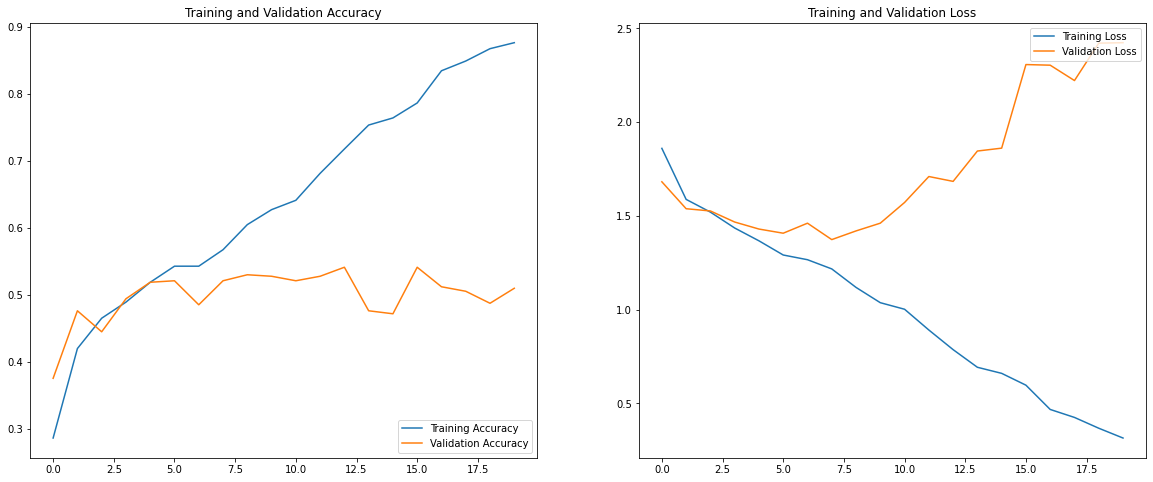

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

` Observations from the plots `
- The model is clearly overfitting, since the training accuracy is high and test accuracy is compartively pretty low
- The validation loss is too high 

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
num_classes = 9

data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  data_augmentation_layer,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

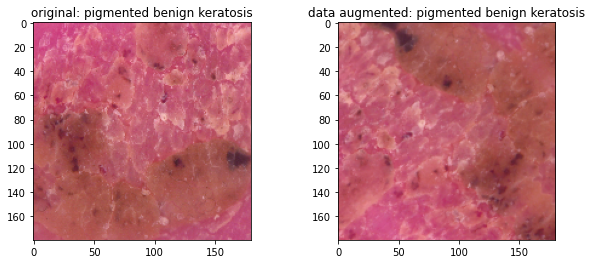

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
img, label = next(iter(train_data_set))
plt.imshow(img[0].numpy().astype("uint8"))
_ = plt.title("original: "+class_names[label[0]])


plt.subplot(1, 2, 2)
plt.imshow(data_augmentation_layer(img)[0].numpy().astype("uint8"))
_ = plt.title("data augmented: "+class_names[label[0]])

In [22]:
epochs = 20
history = model.fit(
  train_data_set,
  validation_data=validation_data_set,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 126ms/step - loss: 2.0141 - accuracy: 0.2266 - val_loss: 1.9257 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 7s 119ms/step - loss: 1.8796 - accuracy: 0.3069 - val_loss: 1.8125 - val_accuracy: 0.3311
Epoch 3/20
56/56 [==============================] - 7s 119ms/step - loss: 1.6926 - accuracy: 0.3962 - val_loss: 1.5667 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 7s 119ms/step - loss: 1.6647 - accuracy: 0.3917 - val_loss: 1.5338 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 7s 119ms/step - loss: 1.5407 - accuracy: 0.4487 - val_loss: 1.4623 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 7s 119ms/step - loss: 1.4924 - accuracy: 0.4738 - val_loss: 1.4366 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 7s 120ms/step - loss: 1.4545 - accuracy: 0.4994 - val_loss: 1.4158 - val_accuracy: 0.5011
Epoch 

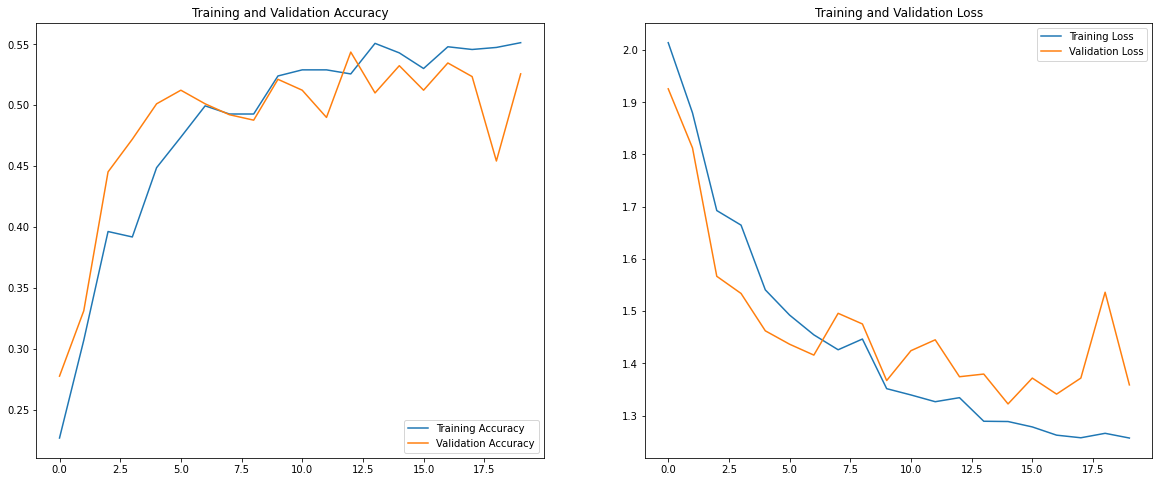

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

`Observations after Augmentation`

- The model is no more overfitting
- However the accuracy fell down for Test and Train set

### Todo:
### Create the model, compile and train the model


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
  
]) 

### Compiling the model

In [25]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_data_set,
  validation_data=validation_data_set,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 117ms/step - loss: 2.0386 - accuracy: 0.2288 - val_loss: 1.8831 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 6s 114ms/step - loss: 1.8325 - accuracy: 0.3477 - val_loss: 1.5767 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 6s 113ms/step - loss: 1.6485 - accuracy: 0.4213 - val_loss: 1.5214 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 6s 113ms/step - loss: 1.5714 - accuracy: 0.4414 - val_loss: 1.4696 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 6s 114ms/step - loss: 1.5439 - accuracy: 0.4509 - val_loss: 1.4249 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 6s 113ms/step - loss: 1.5087 - accuracy: 0.4760 - val_loss: 1.4080 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 6s 113ms/step - loss: 1.4676 - accuracy: 0.5050 - val_loss: 1.3916 - val_accuracy: 0.5078
Epoch 

### Visualizing the results

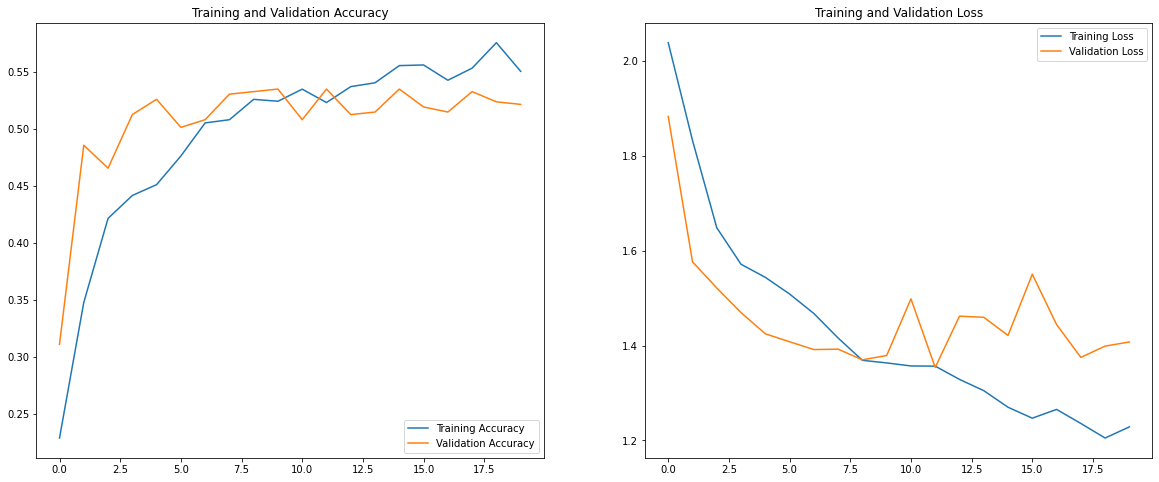

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is no overfit happening in the training, but accuracy is too low

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.

def count_class_fn(counts, batch, num_classes=9):

    labels = batch[1]
    for i in range(num_classes):
        cc = tf.cast(labels == i, tf.int32)
        counts[i] += tf.reduce_sum(cc)
    return counts

initial_state = dict((i, 0) for i in range(num_classes))
counts = train_data_set.reduce(initial_state=initial_state,
                         reduce_func=count_class_fn)

freq_label_tuple = [(ix, class_names[ix], val.numpy()) for ix, val in counts.items()]
freq_label_df = pd.DataFrame(freq_label_tuple, columns=["label_id", "label", "count"])

print(freq_label_df.sort_values(by=['count']).head(10))

   label_id                       label  count
6         6        seborrheic keratosis     58
2         2              dermatofibroma     77
0         0           actinic keratosis     92
8         8             vascular lesion    115
7         7     squamous cell carcinoma    142
4         4                       nevus    277
1         1        basal cell carcinoma    309
3         3                    melanoma    352
5         5  pigmented benign keratosis    370


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Seborrehic Keratosis class has least number of samples (58)

#### - Which classes dominate the data in terms proportionate number of samples?
Following are the classes which dominate the data in terms proportionate number of samples pigmented benign keratosis, melanoma, basal cell carcinom, nevus 

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import Augmentor
path_to_training_dataset=dataset_path+"/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE1F614AED0>: 100%|██████████| 500/500 [00:25<00:00, 19.42 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE1F64D0C10>: 100%|██████████| 500/500 [00:25<00:00, 19.32 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE1F6132ED0>: 100%|██████████| 500/500 [00:28<00:00, 17.69 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE1F61F0510>: 100%|██████████| 500/500 [01:52<00:00,  4.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FE1F6433E50>: 100%|██████████| 500/500 [01:46<00:00,  4.71 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE1F60A4650>:  61%|██████    | 304/500 [00:14<00:11, 17.76 Samples/s]                  

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_34af57e4-4537-447d-b89d-3296046d227e.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_db041b1e-08c0-41ec-a77e-e26c9b21ed8e.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_061e77f4-d0c7-4716-a367-45b6fb27b6f2.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_d0c24922-84ab-4518-8c27-5f09864cdc00.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_0b65c800-9734

In [37]:
path_list_new = [
    (
        path_list_ix,
        os.path.basename(path_list_ix),
        os.path.basename(os.path.dirname(os.path.dirname(path_list_ix)))
    )
    for path_list_ix in path_list
]

In [38]:
df2 = pd.DataFrame(path_list_new,columns = ['Path','Image', 'Label'])
df2.sample(5)

,Path,Image,Label
2035,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma_original_ISIC_0001126.jpg_5abeecf4-34...,melanoma
2939,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion_original_ISIC_0033565.jpg_83b7...,vascular lesion
1260,/content/gdrive/MyDrive/Skin cancer ISIC The I...,pigmented benign keratosis_original_ISIC_00259...,pigmented benign keratosis
4214,/content/gdrive/MyDrive/Skin cancer ISIC The I...,nevus_original_ISIC_0026702.jpg_1065e0de-7e65-...,nevus
1722,/content/gdrive/MyDrive/Skin cancer ISIC The I...,squamous cell carcinoma_original_ISIC_0025411....,squamous cell carcinoma


In [39]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
pigmented benign keratosis    500
squamous cell carcinoma       500
melanoma                      500
vascular lesion               500
dermatofibroma                500
seborrheic keratosis          500
nevus                         500
Name: Label, dtype: int64

In [41]:
import shutil
import os


samples_dir = dataset_path+"/Balanced_Samples/"
shutil.rmtree(samples_dir, ignore_errors=True)
os.makedirs(samples_dir, exist_ok=True)

for label in os.listdir(dataset_path+"/Train/"):
	os.makedirs(samples_dir+label, exist_ok=True)


for each_fp in df2["Path"].tolist():
    label, each_fn = os.path.basename(os.path.dirname(os.path.dirname(each_fp))), os.path.basename(each_fp)
    os.rename(each_fp.replace("\\", "/"), samples_dir+f"{label}/{each_fn}")

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [43]:
data_dir_train=samples_dir
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [55]:
## your code goes here
num_classes = 9

model =  tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
   tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
   tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
   tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [56]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [57]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/50
113/113 [==============================] - 17s 138ms/step - loss: 2.2324 - accuracy: 0.1097 - val_loss: 2.1972 - val_accuracy: 0.1133
Epoch 2/50
113/113 [==============================] - 16s 134ms/step - loss: 2.1843 - accuracy: 0.1256 - val_loss: 2.1467 - val_accuracy: 0.1733
Epoch 3/50
113/113 [==============================] - 16s 135ms/step - loss: 2.0196 - accuracy: 0.2014 - val_loss: 2.0409 - val_accuracy: 0.2922
Epoch 4/50
113/113 [==============================] - 16s 135ms/step - loss: 1.8806 - accuracy: 0.2458 - val_loss: 1.9586 - val_accuracy: 0.3244
Epoch 5/50
113/113 [==============================] - 18s 148ms/step - loss: 1.7714 - accuracy: 0.3114 - val_loss: 1.9081 - val_accuracy: 0.3333
Epoch 6/50
113/113 [==============================] - 16s 134ms/step - loss: 1.7083 - accuracy: 0.3308 - val_loss: 1.7496 - val_accuracy: 0.3600
Epoch 7/50
113/113 [==============================] - 16s 134ms/step - loss: 1.6260 - accuracy: 0.3686 - val_loss: 1.6144 - val_ac

#### **Todo:**  Visualize the model results

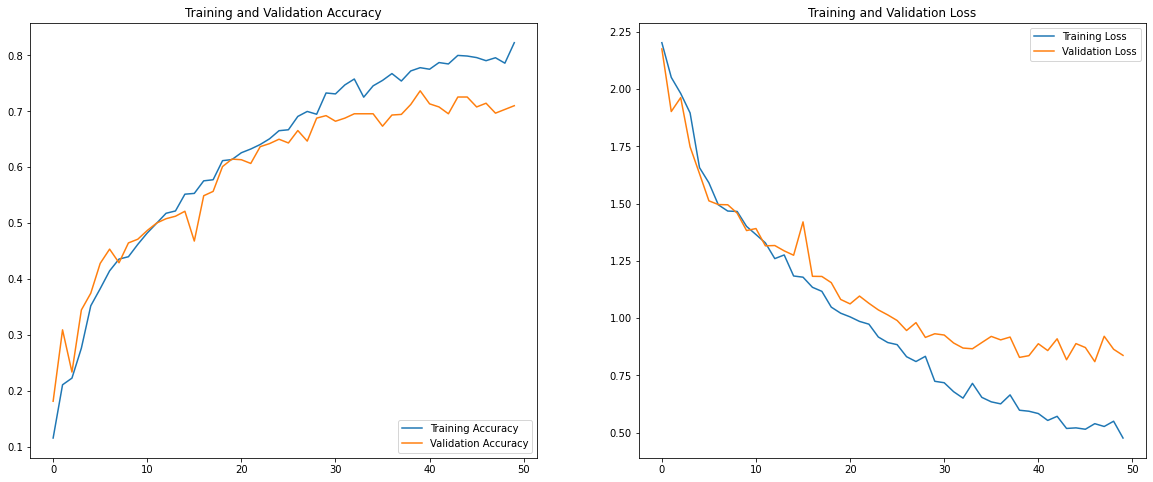

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes Class Reblance helped us overcome overfitting